# Introduction 

In this project, I used the Chinook database to answer some common business questions. Chinook data model represents a digital media store, including tables for artists, albums, media tracks, invoices, and customers. You can take a look at this [here](https://github.com/lerocha/chinook-database). 

This is the schema of Chinook database:
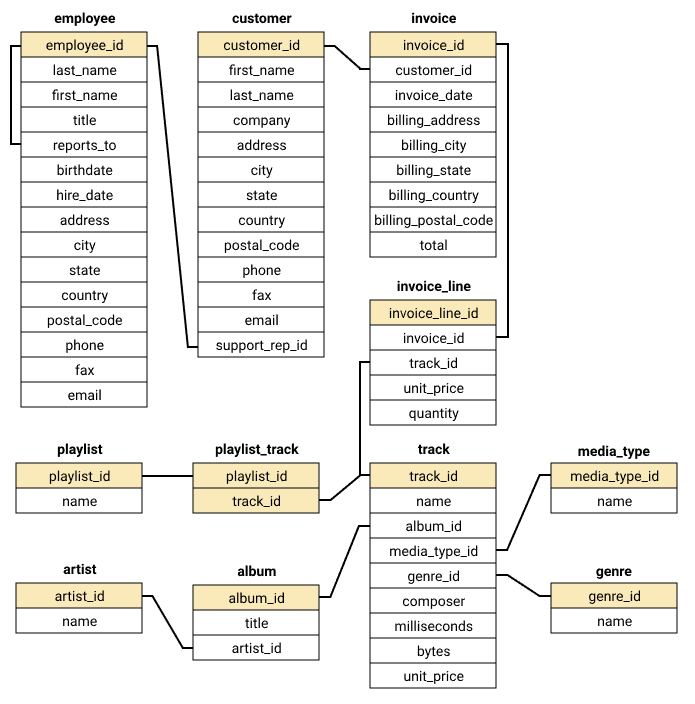

# Creating Helper Functions

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

In [2]:
#Function that takes a SQL query and returns a pandas dataframe
def run_query(SQL_query):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(SQL_query, conn)

#Function that executes a SQL command
def run_command(SQL_command):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(SQL_command)

#Returns a list of all tables and views in the database
def show_tables():
    query = '''
        SELECT 
            name,
            type
        FROM sqlite_master
        WHERE type IN ("table", "view");
    '''
    return run_query(query)
    
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


# Selecting New Albums to Purchase

Let's suppose that Chinook record store has just signed a deal with a new record label which is specialized in artists from the USA, and they want to advertise new albums. We're interested in finding out which genres sell the best in the USA.

In [18]:
q1 = '''
        WITH 
            tracks_sold_usa AS
                (
                SELECT
                    il.*,
                    c.country
                FROM invoice_line il
                INNER JOIN invoice i ON i.invoice_id = il.invoice_id
                INNER JOIN customer c ON c.customer_id = i.customer_id
                WHERE c.country="USA"
                )
        
        SELECT 
            g.name,
            COUNT(tsu.invoice_id) sold_quantity,
            CAST(COUNT(tsu.invoice_id) as float) / CAST(( SELECT
                                                        COUNT(*)
                                                        FROM tracks_sold_usa
                                                   ) as float) sold_per
        FROM tracks_sold_usa tsu
        INNER JOIN track t ON tsu.track_id = t.track_id
        INNER JOIN genre g ON t.genre_id = g.genre_id
        GROUP BY 1 ORDER BY 2 DESC
        LIMIT 10
        ;
        
      '''

genre_sales_usa = run_query(q1)
genre_sales_usa

,name,sold_quantity,sold_per
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


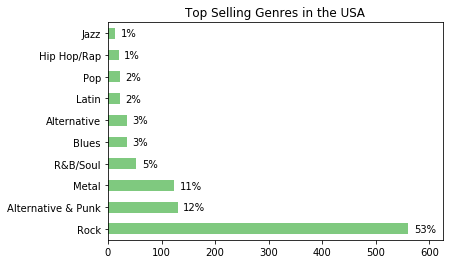

In [20]:
genre_sales_usa.plot.barh(x='name', 
                          y='sold_quantity',
                          colormap = plt.cm.Accent,
                          legend = None,
                          xlim = (0, 625),
                          title = 'Top Selling Genres in the USA'
                         )

plt.ylabel('')

for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label, "sold_quantity"]
    label = (genre_sales_usa.loc[label, "sold_per"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))
    
plt.show()

The graphics show that the top 3 genres are:
- Rock
- Alternative & Punk
- Metal

These three genres make up 76% of total sales, so we should be on the lookout for artists and albums from those genres. Especially Rock, which represents 53% of the sales.

# Analyzing Employee Sales Performance

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. In this step I wanted to see if any sales support agent is performing either better or worse than the others.

In [22]:
q2 = '''
    WITH
        total_sales AS
        (
            SELECT
                i.customer_id,
                c.support_rep_id,
                SUM(i.total) total_usd
            FROM invoice i
            INNER JOIN customer c ON i.customer_id = c.customer_id
            GROUP BY 1,2
        )
    SELECT
        e.first_name || " " || e.last_name employee_name,
        e.title,
        e.hire_date,
        SUM(ts.total_usd) total_sales
    FROM employee e
    INNER JOIN total_sales ts ON e.employee_id = ts.support_rep_id
    GROUP BY 1
    
'''

employees_perfomance = run_query(q2)
employees_perfomance

,employee_name,title,hire_date,total_sales
0,Jane Peacock,Sales Support Agent,2017-04-01 00:00:00,1731.51
1,Margaret Park,Sales Support Agent,2017-05-03 00:00:00,1584.00
2,Steve Johnson,Sales Support Agent,2017-10-17 00:00:00,1393.92


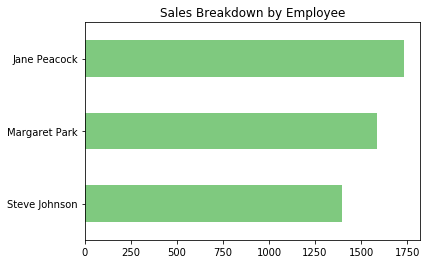

In [25]:
employees_perfomance.sort_values('total_sales', inplace=True)
employees_perfomance.plot.barh(x='employee_name', 
                               y='total_sales',
                               legend=False,
                               title='Sales Breakdown by Employee',
                               colormap=plt.cm.Accent
                              )
plt.ylabel('')
plt.show()

There is a difference in sales between Jane (top employee) and Steve (bottom employee), but it corresponds with the differences in their hiring dates.

# Analyzing Sales by Country
Let's make an analysis of sales data for customers from each different country. I calculated data, for each country, on the:
- total number of customers
- total value of sales
- average value of sales per customer
- average order value

Because there are a number of countries with only one customer, I grouped these customers as "Other".

In [27]:
q3= '''
    WITH country_name AS
    (
    SELECT 
        CASE
            WHEN(
                SELECT
                    COUNT(*)
                FROM customer
                WHERE country = c.country
                ) = 1 THEN "Others"
            ELSE c.country
        END country,
        c.customer_id,
        i.*
        FROM customer c
        INNER JOIN invoice i ON c.customer_id = i.customer_id
    )
    

    SELECT 
        country,
        COUNT(distinct customer_id) num_customers,
        SUM(total) total_sales,
        CAST(SUM(total) as float) / CAST(COUNT(distinct customer_id) as float) avg_sales,
        CAST(SUM(total) as float) / CAST(COUNT(distinct invoice_id) as float) avg_order,
        CASE
            WHEN country = "Others" THEN 1
            ELSE 0
        END sort
    FROM country_name
    GROUP BY 1
    ORDER BY sort, total_sales DESC
'''

run_query(q3)

,country,num_customers,total_sales,avg_sales,avg_order,sort
0,USA,13,1040.49,80.037692,7.942672,0
1,Canada,8,535.59,66.948750,7.047237,0
2,Brazil,5,427.68,85.536000,7.011148,0
3,France,5,389.07,77.814000,7.781400,0
4,Germany,4,334.62,83.655000,8.161463,0
5,Czech Republic,2,273.24,136.620000,9.108000,0
6,United Kingdom,3,245.52,81.840000,8.768571,0
7,Portugal,2,185.13,92.565000,6.383793,0
8,India,2,183.15,91.575000,8.721429,0
9,Others,15,1094.94,72.996000,7.448571,1


# Visualizing Sales by Country
Below I'll show you a series of visualizations which communicate the findings from the previous section.

In [8]:
country_sales = run_query(q3)
country_sales.set_index('country', drop=True, inplace=True)
del country_sales.index.name
country_sales = country_sales.iloc[:, 0:4]
country_sales

,num_customers,total_sales,avg_sales,avg_order
USA,13,1040.49,80.037692,7.942672
Canada,8,535.59,66.948750,7.047237
Brazil,5,427.68,85.536000,7.011148
France,5,389.07,77.814000,7.781400
Germany,4,334.62,83.655000,8.161463
Czech Republic,2,273.24,136.620000,9.108000
United Kingdom,3,245.52,81.840000,8.768571
Portugal,2,185.13,92.565000,6.383793
India,2,183.15,91.575000,8.721429
Others,15,1094.94,72.996000,7.448571


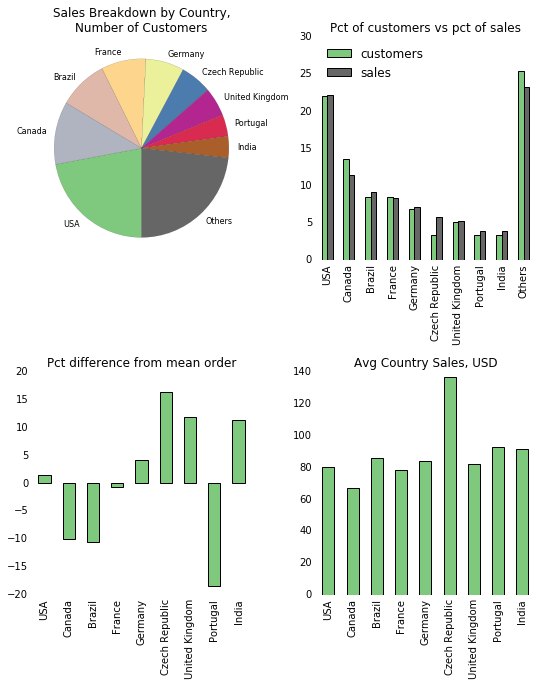

In [71]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)

sales_breakdown = country_sales['total_sales'].copy().rename('')
sales_breakdown.plot.pie(ax=ax1, 
                        title='Sales Breakdown by Country,\nNumber of Customers',
                        startangle=-90,
                        counterclock=False,
                        colormap = plt.cm.Accent,
                        wedgeprops = {'linewidth': 0.1},
                        fontsize=8
                       )

cols = ['num_customers', 'total_sales']
customers_vs_sales = country_sales[cols].copy()
customers_vs_sales.index.name = '' 
for c in cols:
    customers_vs_sales[c] /= customers_vs_sales[c].sum() / 100
customers_vs_sales.plot.bar(ax=ax2,
                            title='Pct of customers vs pct of sales',
                            colormap = plt.cm.Accent
                           )
ax2.legend(labels=['customers', 'sales'], loc='upper left', frameon = False)
ax2.tick_params(bottom="off", left="off", top="off", right="off")
for key, spine in ax2.spines.items():
    spine.set_visible(False)

avg_order = country_sales['avg_order'].copy()
dif_from_mean_order = avg_order * 100 / avg_order.mean() - 100
dif_from_mean_order.drop('Others', inplace=True)
dif_from_mean_order.plot.bar(
                            ax = ax3,
                            title = 'Pct difference from mean order',
                            colormap = plt.cm.Accent
                            )
ax3.tick_params(bottom="off", left="off", top="off", right="off")
for key, spine in ax3.spines.items():
    spine.set_visible(False)
    
    
avg_sales = country_sales['avg_sales'].copy()
avg_sales.drop('Others', inplace=True)
avg_sales.plot.bar(
                    ax = ax4,
                    title = 'Avg Sales by Country, USD',
                    colormap = plt.cm.Accent
)
ax4.tick_params(bottom="off", left="off", top="off", right="off")
for key, spine in ax4.spines.items():
    spine.set_visible(False)


plt.show()

Based on the data, there may be an opportunity in the following countries:
- Czech Republic
- United Kingdom
- India

Since the amount of data from each of these countries is relatively low, I would not recommend spending too much money on new marketing campaigns, because the sample size doesn't give us enough information to be confident about it. A safer move might be making small investments in campaigns to see if these trends hold, collecting data and analyzing the new customers.


# Albums vs Individual Tracks

The Chinoook store is setup in a way that allows customers to make purchases in one of the two ways:

- purchase a whole album
- purchase a collection of one or more individual tracks

The store does not let customers purchase a whole album, and then add individual tracks to that same purchase. Management is considering changing this purchasing strategy to save money. They want to offer only the most popular tracks from each album, instead of purchasing every track. They need to know what percentage of purchases are individual tracks vs whole albums, so management can use this data to understand the effect this decision might have on overall revenue.

In [28]:
#returns a table with individual tracks purchases vs albums purchases.
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668



Album purchases account for 18.6% of purchases. Based on this data, I would recommend against purchasing only select tracks from albums from record companies, since there is potential to lose one fifth of revenue.